In [49]:
import kagglehub
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [50]:
# Download a mirror of CIFAR-10 that has images extracted into folders
# This version by 'swaroopkml' puts images in folders named by their class (e.g., 'dog', 'airplane')
# This creates a structure compatible with torchvision.datasets.ImageFolder
path = kagglehub.dataset_download("swaroopkml/cifar10-pngs-in-folders")

print(f"Data downloaded to: {path}")

Data downloaded to: /Users/deepakramalingam/.cache/kagglehub/datasets/swaroopkml/cifar10-pngs-in-folders/versions/1


Train path: /Users/deepakramalingam/.cache/kagglehub/datasets/swaroopkml/cifar10-pngs-in-folders/versions/1/cifar10/cifar10/train
Test path:  /Users/deepakramalingam/.cache/kagglehub/datasets/swaroopkml/cifar10-pngs-in-folders/versions/1/cifar10/cifar10/test
--- Training Data Samples ---


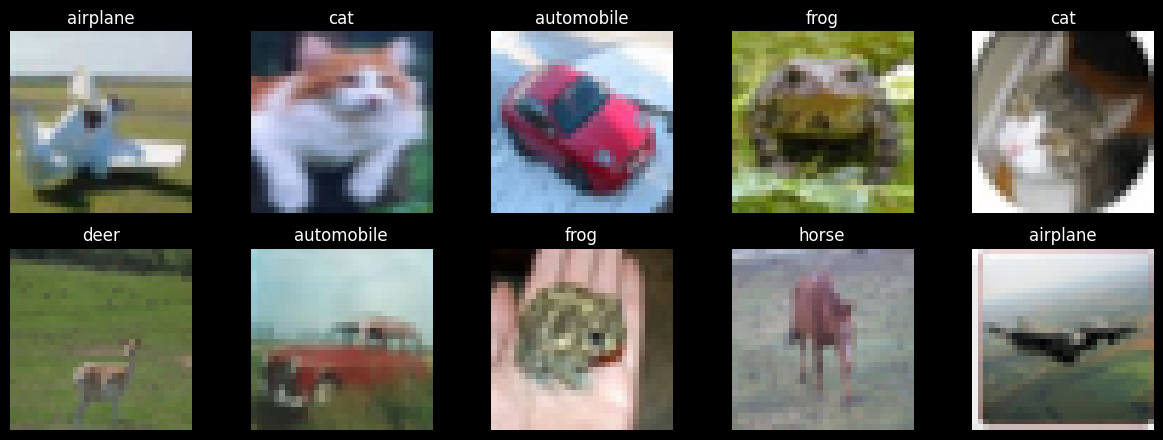

In [51]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# 1. Update the paths with the double 'cifar10' folder
# We can construct it relative to the 'path' variable you already have
base_dir = os.path.join(path, 'cifar10', 'cifar10')
train_path = os.path.join(base_dir, 'train')
test_path = os.path.join(base_dir, 'test')

print(f"Train path: {train_path}")
print(f"Test path:  {test_path}")

# 2. Reuse our helper functions
def get_random_images(root_path, num_images=5):
    images = []
    titles = []

    if not os.path.exists(root_path):
        print(f"Error: Path still not found: {root_path}")
        return [], []

    classes = [d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]

    for _ in range(num_images):
        random_class = random.choice(classes)
        class_path = os.path.join(root_path, random_class)
        files = os.listdir(class_path)
        if len(files) > 0:
            random_file = random.choice(files)
            img = Image.open(os.path.join(class_path, random_file))
            images.append(img)
            titles.append(f"{random_class}")

    return images, titles

def show_images(images, title_texts):
    if not images: return
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(15, 8))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image)
        plt.title(title_text, fontsize=12)
        plt.axis('off')
        index += 1
    plt.show()

# --- Verification ---
print("--- Training Data Samples ---")
train_imgs, train_labels = get_random_images(train_path, num_images=10)
show_images(train_imgs, train_labels)

In [52]:
# 1. init random weights
# 2. loop:
#     2a. predict
#     2b. loss function
#     2c. gradient
#     2d. update weights

# 0. create dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # 50% chance to flip
    transforms.RandomCrop(32, padding=4), # Shift image slightly
    transforms.ToTensor(),
    # Normalize is crucial for convergence!
    # These are the standard means/stds for CIFAR-10
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_dataset = ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 1. params, bias, activation functions
net = nn.Sequential(
    nn.Linear(32 * 32 * 3, 1024), # width height rgb
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 10) # 10 classifications
)

# optimizer
opt = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

# criterion
criterion = nn.BCEWithLogitsLoss()
loss = None

# 2. loop
epochs = 25
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # 2a. predict
        # flatten
        images = images.view(images.size(0), -1)
        target_one_hot_encoding = F.one_hot(labels, num_classes=10).float()
        # y_pred are the logits
        y_pred = net(images)
        # 2b. loss function
        loss = criterion(y_pred, target_one_hot_encoding)
        # 2c. gradient
        opt.zero_grad()
        loss.backward()
        # 2d. update weights
        opt.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1} complete. Avg Loss: {running_loss/len(train_loader):.4f}")

Epoch 1 complete. Avg Loss: 0.2856
Epoch 2 complete. Avg Loss: 0.2652
Epoch 3 complete. Avg Loss: 0.2587
Epoch 4 complete. Avg Loss: 0.2537
Epoch 5 complete. Avg Loss: 0.2500
Epoch 6 complete. Avg Loss: 0.2471
Epoch 7 complete. Avg Loss: 0.2440
Epoch 8 complete. Avg Loss: 0.2435
Epoch 9 complete. Avg Loss: 0.2420
Epoch 10 complete. Avg Loss: 0.2402
Epoch 11 complete. Avg Loss: 0.2297
Epoch 12 complete. Avg Loss: 0.2251
Epoch 13 complete. Avg Loss: 0.2236
Epoch 14 complete. Avg Loss: 0.2219
Epoch 15 complete. Avg Loss: 0.2206
Epoch 16 complete. Avg Loss: 0.2198
Epoch 17 complete. Avg Loss: 0.2193
Epoch 18 complete. Avg Loss: 0.2182
Epoch 19 complete. Avg Loss: 0.2175
Epoch 20 complete. Avg Loss: 0.2164
Epoch 21 complete. Avg Loss: 0.2153
Epoch 22 complete. Avg Loss: 0.2156
Epoch 23 complete. Avg Loss: 0.2157
Epoch 24 complete. Avg Loss: 0.2151
Epoch 25 complete. Avg Loss: 0.2145


Evaluating...

Overall Accuracy: 53.10%


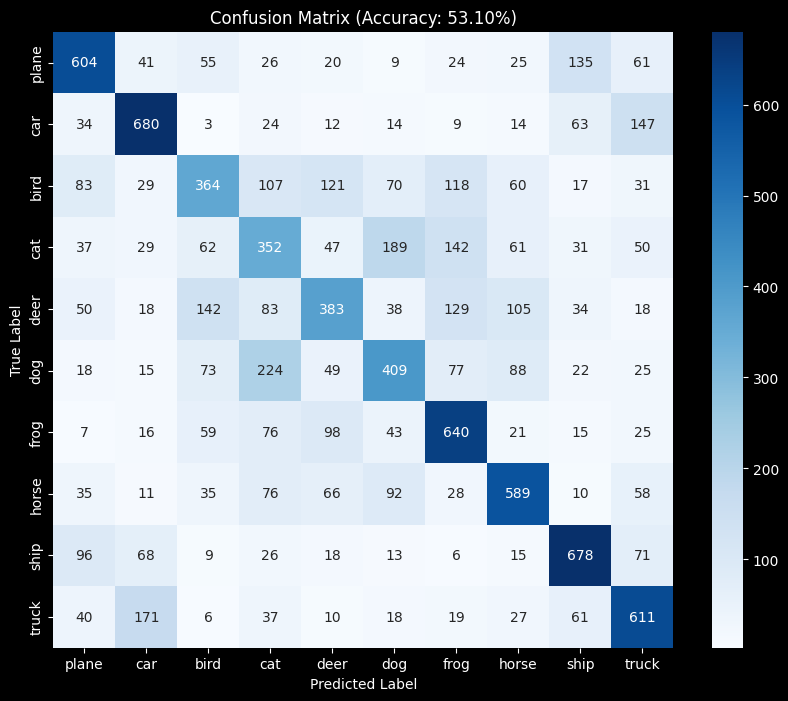

array([[604,  41,  55,  26,  20,   9,  24,  25, 135,  61],
       [ 34, 680,   3,  24,  12,  14,   9,  14,  63, 147],
       [ 83,  29, 364, 107, 121,  70, 118,  60,  17,  31],
       [ 37,  29,  62, 352,  47, 189, 142,  61,  31,  50],
       [ 50,  18, 142,  83, 383,  38, 129, 105,  34,  18],
       [ 18,  15,  73, 224,  49, 409,  77,  88,  22,  25],
       [  7,  16,  59,  76,  98,  43, 640,  21,  15,  25],
       [ 35,  11,  35,  76,  66,  92,  28, 589,  10,  58],
       [ 96,  68,   9,  26,  18,  13,   6,  15, 678,  71],
       [ 40, 171,   6,  37,  10,  18,  19,  27,  61, 611]])

In [53]:
from sklearn.metrics import confusion_matrix, accuracy_score # Added accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Ensure test_path and transform are defined in your environment
test_dataset = ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def evaluate_confusion_matrix(model, loader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    print("Evaluating...")
    with torch.no_grad():
        for images, labels in loader:
            # Flatten images [Batch, 3072]
            # Note: Remove this .view() line if you switch to a CNN later!
            images = images.view(images.size(0), -1)

            # Get model outputs (logits)
            logits = model(images)

            # Convert logits to probabilities (0-1)
            probs = torch.sigmoid(logits)

            # Get the predicted class index (highest probability)
            _, preds = torch.max(probs, 1)

            # Append predictions and labels to lists
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- NEW: Calculate and Print Accuracy ---
    acc = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Accuracy: {acc * 100:.2f}%")
    # -----------------------------------------

    # Calculate Confusion Matrix using sklearn
    cm = confusion_matrix(all_labels, all_preds)

    # Plot using Seaborn
    plt.figure(figsize=(10, 8))

    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else "auto",
                yticklabels=class_names if class_names else "auto")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (Accuracy: {acc*100:.2f}%)') # Added accuracy to title too
    plt.show()

    return cm

# --- Example Usage ---

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Run the function
# (Ensure 'net' is your trained model and test_loader is defined)
evaluate_confusion_matrix(net, test_loader, class_names=classes)